<a href="https://colab.research.google.com/github/Belac44/Deep-Learning/blob/main/TB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image
import tensorflow as tf

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
img_height,img_width=150,150
batch_size=16

# Normal = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/TB_Chest_Radiography_Database/Normal',
#     image_size=(img_height,img_width),
#     batch_size=batch_size
    
# )

# Tuberculosis = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis',
#     image_size=(img_height,img_width),
#     batch_size=batch_size
    
# )


In [53]:
normal_dir = "/content/drive/MyDrive/TB_Chest_Radiography_Database/Normal/"
tb_dir = "/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis/"

normal_img = []
tb_img = []

normal_img.extend(glob.glob(normal_dir + '*.' + 'png'))
tb_img.extend(glob.glob(tb_dir + '*.' + 'png'))

In [54]:
train = []

for img in normal_img:
  train.append((img, 0))

for i in range(1500):
  train.append((tb_img[i], 1))

In [55]:
train_data = pd.DataFrame(train, columns=["Image", "Label"])
train_data.head()

,Image,Label
0,/content/drive/MyDrive/TB_Chest_Radiography_Da...,0
1,/content/drive/MyDrive/TB_Chest_Radiography_Da...,0
2,/content/drive/MyDrive/TB_Chest_Radiography_Da...,0
3,/content/drive/MyDrive/TB_Chest_Radiography_Da...,0
4,/content/drive/MyDrive/TB_Chest_Radiography_Da...,0


In [56]:
train_data.groupby("Label").count()

,Image
Label,
0,3500
1,700


## Pre Processing

In [57]:
def preprocess_image(image):
  img = Image.open(image)
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  return img_gray

def preprocess_image2(image):
  img = cv2.imread(str(image))
  img = cv2.resize(img, (28,28))
  if img.shape[2] ==1:
      img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img=np.array(img)
  img = img/255
  return img.reshape(-1,28,28, 3)

In [58]:
from tqdm import tqdm

train_data = []
train_labels = []

from keras.utils.np_utils import to_categorical



for img in tqdm(normal_img):
    img = preprocess_image2(img)
    label = "Normal"
    train_data.append(img)
    train_labels.append(label)
                      
        
for img in tqdm(tb_img):
    img = preprocess_image2(img)
    label = "Tuberculosis"
    train_data.append(img)
    train_labels.append(label)
    


train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

100%|██████████| 700/700 [00:06<00:00, 100.13it/s]

Total number of validation examples:  (4200, 1, 28, 28, 3)
Total number of labels: (4200,)


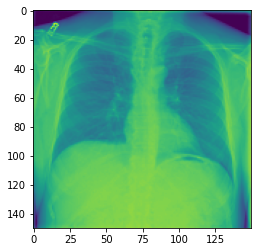

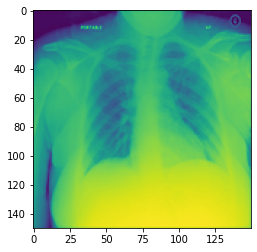

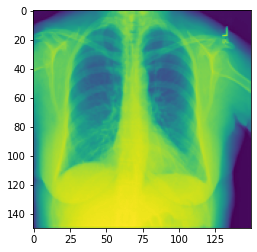

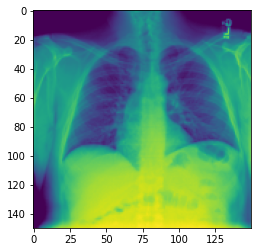

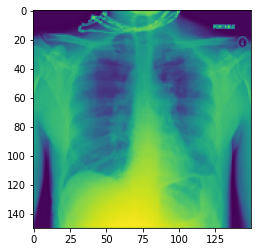

In [59]:
for i in range(5):
  img = Image.open(normal_img[i])
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  plt.imshow(img_gray)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


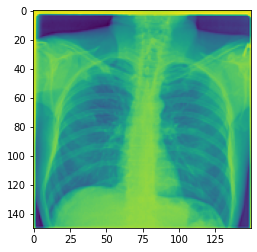

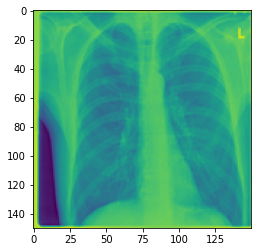

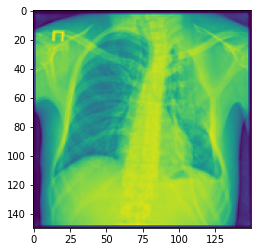

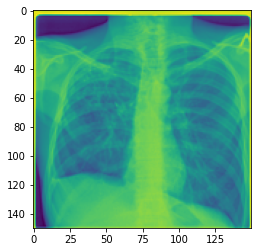

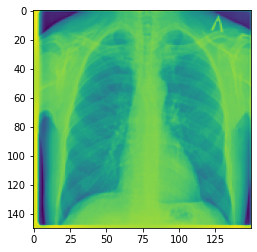

In [60]:
for i in range(5):
  img = Image.open(tb_img[i])
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  plt.imshow(img_gray)
  plt.show()

In [61]:
train_data1.shape

(4200, 1, 28, 28, 3)

In [62]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal


In [63]:
train_labels1['label']=train_labels1['label'].map({'Normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

In [64]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

In [65]:
train_data2 =train_data2.reshape(-1,28,28, 3)

In [66]:
train_data2.shape

(7000, 28, 28, 3)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.13, random_state=42)

In [68]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(28, 28, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
      
  ]
)

In [69]:
import tensorflow as tf
from tensorflow.keras import  layers, models

def create_model():
  model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu')
    
])
  model.add(layers.Flatten())
  model.add(layers.Dense(640, activation='tanh'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(564, activation='tanh'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='softmax'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [70]:
model = create_model()

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          16448     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [71]:
model.fit(np.array(X_train), np.array(y_train), epochs=200, validation_data=(np.array(X_test), np.array(y_test)) )

Epoch 1/200
191/191 [==============================] - 2s 7ms/step - loss: 0.5634 - accuracy: 0.7639 - val_loss: 0.4281 - val_accuracy: 0.9407
Epoch 2/200
191/191 [==============================] - 1s 5ms/step - loss: 0.4121 - accuracy: 0.9033 - val_loss: 0.3534 - val_accuracy: 0.9275
Epoch 3/200
191/191 [==============================] - 1s 5ms/step - loss: 0.3342 - accuracy: 0.9259 - val_loss: 0.2941 - val_accuracy: 0.9440
Epoch 4/200
191/191 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.9476 - val_loss: 0.2735 - val_accuracy: 0.9286
Epoch 5/200
191/191 [==============================] - 1s 5ms/step - loss: 0.2266 - accuracy: 0.9507 - val_loss: 0.1871 - val_accuracy: 0.9692
Epoch 6/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1964 - accuracy: 0.9552 - val_loss: 0.2236 - val_accuracy: 0.9209
Epoch 7/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1802 - accuracy: 0.9589 - val_loss: 0.2384 - val_accuracy: 0.9275

In [72]:
y_pred=model.predict(X_test)
y_pred2 = np.zeros((y_test.shape[0],1))
for row in range(y_pred.shape[0]):
  for col in range(2):
    if y_pred[row][col] < 0:
      y_pred2[row] = 0
    if y_pred[row][col] > 0:
      y_pred2[row] = 1

29/29 [==============================] - 0s 2ms/step


In [73]:
from sklearn.metrics import confusion_matrix

sm = confusion_matrix(y_true=y_test, y_pred=y_pred2)

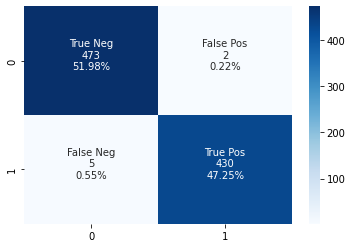

In [74]:
from seaborn import heatmap

group_names=["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in sm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in sm.flatten()/np.sum(sm)]
labels = [f"{v1}\n{v2}\n{v3}\n" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

heatmap(sm, annot=labels, fmt="", cmap="Blues")

In [75]:
json_file = model.to_json()
with open("finalmodel.json", "w") as data:
  data.write(json_file)

model.save_weights("finalmodel.h5")

In [76]:
# json_file = model.to_yaml()
# with open("finalmodel.yaml", "w") as data:
#   data.write(json_file)

# model.save_weights("finalmodel1.h5")

In [77]:
 model.save("modelfinal2.h5")

In [78]:
 import joblib

 joblib.dump(model, 'model_main.pkl')

['model_main.pkl']

In [79]:
# model = create_model()
# model.load_weights(checkpoint_path)
# loss, acc = model.evaluate(X_test, y_test, verbose=2)

In [80]:
# model = joblib.load("/content/model_main.pkl")
# model(preprocess_image2(f"{tb_dir}/Tuberculosis/Tuberculosis-1.png"))

In [81]:
# model(preprocess_image2("Normal/Normal-1.png"))

In [82]:
# model(preprocess_image2("Normal/Normal-41.png"))

In [83]:
# result = model(preprocess_image2("Tuberculosis/Tuberculosis-1.png"))

In [84]:
# prob_nm = float(result[0][0])
# prob_tb = float(result[0][1])

In [85]:
# print(prob_tb)
# print(prob_nm)

In [ ]:
def preprocess_image2(image):
  img = cv2.imread(str(image))
  img = cv2.resize(img, (28,28))
  if img.shape[2] ==1:
      img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img=np.array(img)
  img = img/255
  return img.reshape(-1,28,28, 3)

In [86]:
from google.colab import files

files.download("/content/modelfinal2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
from keras.models import model_from_json

file = open("/content/finalmodel.json", 'r')
loaded_model_json = file.read()
file.close()

In [106]:
model = model_from_json(loaded_model_json)
model.load_weights("/content/finalmodel.h5")
result = model.predict(preprocess_image2(f"{normal_dir}/Normal-150.png"))
result

1/1 [==============================] - 0s 130ms/step


array([[ 3.7844636, -3.7517884]], dtype=float32)

In [104]:
model = model_from_json(loaded_model_json)
model.load_weights("/content/finalmodel.h5")
result = model.predict(preprocess_image2(f"{tb_dir}/Tuberculosis-345.png"))
result

1/1 [==============================] - 0s 91ms/step


array([[-3.0288672,  2.7920465]], dtype=float32)